# MMN-11
Roman Smirnov

## Preparatory Setup

### Library Imports

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Preparatory Setup

### PyPlot Defaults Configuration

In [3]:
plt.rcParams['figure.figsize'] = [14,8]
plt.rcParams['figure.frameon'] = False
plt.rcParams['figure.edgecolor'] = 'none'  
plt.rcParams['figure.facecolor'] = 'none' 
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['ytick.labelright'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labeltop'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['image.interpolation'] = 'bilinear'

## Question 1

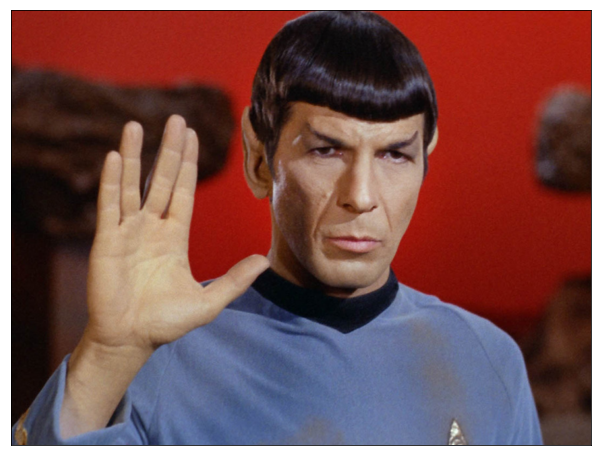

In [325]:
img = cv2.imread('spock.jpg', cv2.IMREAD_COLOR)[...,::-1]  # converted to rgb on the spot
plt.imshow(img)

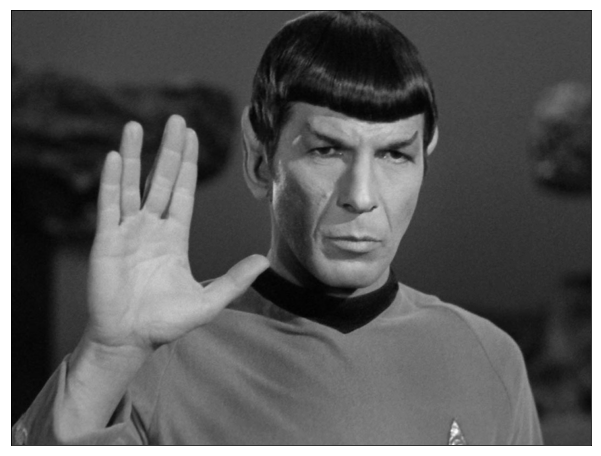

In [326]:
# convert to grayscale monochrome since that's the input format for the algorithms below
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

### Canny Edge Detector

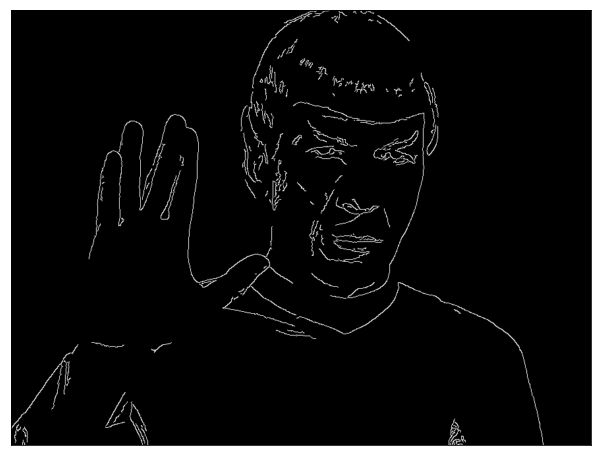

In [327]:
edges = cv2.Canny(gray, 89, 144)
plt.imshow(edges, cmap='gray')

### Harris Corner Detection

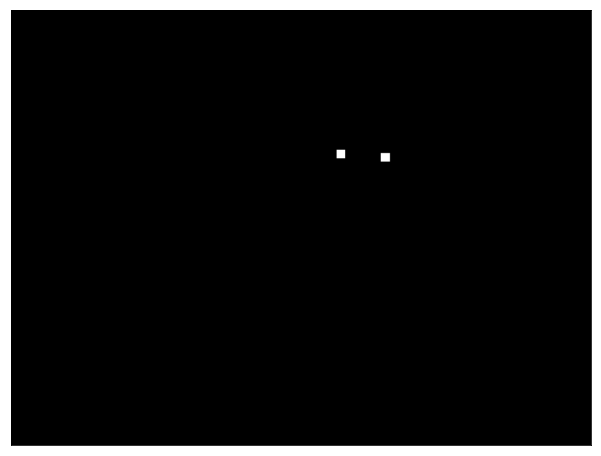

In [328]:
##### perform corner detection
corners = cv2.cornerHarris(gray,blockSize=2,ksize=3,k=0.08)

# discard detection values below threshold
# rationale: large positive detection values indicate corners
DETECTION_THRESHOLD = 1.0e-4
corners = np.where(corners>1.0e-4,255,0)


# discard sparse detections, and group together dense detection regions
# rationale: the eye corner areas are apparently dense with various corners
corners = cv2.medianBlur(corners.astype(np.uint8), 3)

# dilate detections for a clearer visualization
corners = cv2.dilate(corners, kernel=np.ones((13,13)), iterations=1)

# visualize detection map
plt.imshow(corners, cmap='gray')

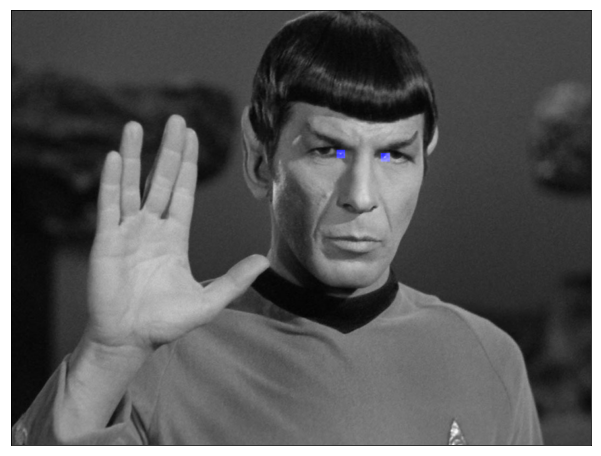

In [329]:
# expand the monochrome image to rgb by duplicating the gray channel
corners_overlay = np.repeat(gray[:,:,None],repeats=3,axis=2)

# mark detection points with blue overlay
corners_overlay[...,2] = np.maximum(corners_overlay[...,2], corners)

# visualize grayscale image with blue overlay detection marks
plt.imshow(corners_overlay)

Sadly, pointed ear detections are not as easy to isolate :)

### Scale Invariant Feature Transform (SIFT)

In [330]:
# extract corner point coordinates by finding centroids of connected components
eye_corner_coordinates = cv2.connectedComponentsWithStats(corners)[3][1:,:]

# convert coordinates to Keypoint type
eye_corner_keypoints = [cv2.KeyPoint(crd[0], crd[1], 13) for crd in eye_corner_coordinates]

# compute SIFT descriptors from corner keypoints
sift = cv2.xfeatures2d.SIFT_create()
eye_corner_descriptors = [sift.compute(gray,[kp])[1] for kp in eye_corner_keypoints]

print(eye_corner_descriptors)

[array([[   5.,   83.,   90.,    6.,    7.,   44.,   22.,    2.,    7.,
         113.,  113.,    3.,    4.,   16.,    5.,    2.,   13.,  107.,
          51.,    6.,    8.,    2.,    3.,    4.,   13.,   42.,   25.,
          12.,   10.,    5.,    6.,    3.,    8.,   13.,  111.,   33.,
           9.,   74.,   81.,   48.,   14.,   75.,   77.,   27.,   17.,
          75.,  113.,   61.,   22.,  113.,   95.,    3.,    3.,   17.,
          74.,   17.,   86.,   54.,   37.,    9.,    8.,    5.,    6.,
          31.,    9.,    4.,    4.,    3.,    1.,   33.,  113.,   44.,
           9.,    5.,   12.,   19.,   15.,   54.,  113.,   36.,   43.,
           6.,    5.,   19.,   40.,   81.,   59.,   30.,  113.,    4.,
           0.,    2.,   18.,    7.,    4.,   76.,    4.,    4.,    3.,
           4.,    3.,    9.,   14.,    6.,    1.,    3.,   10.,   62.,
          24.,    7.,    4.,    3.,   66.,    5.,    2.,   74.,   40.,
          12.,    1.,   14.,  113.,    8.,    0.,    2.,   13.,    2.,
     

### SIFT Pattern Matching

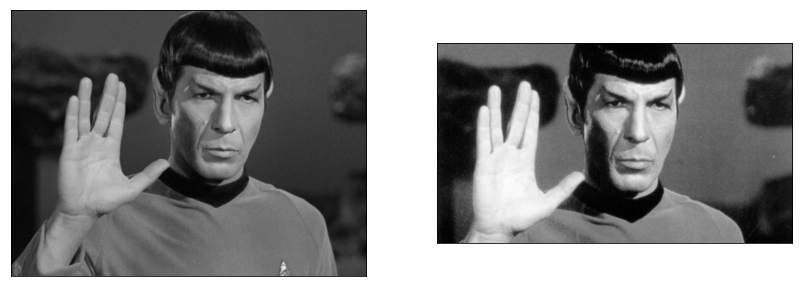

In [331]:
# load and visualize images
img1 = cv2.imread('spock.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('spock2.jpg', cv2.IMREAD_GRAYSCALE)
ax1, ax2 = plt.subplots(1,2)[1]
ax1.imshow(img1, cmap='gray'); ax2.imshow(img2, cmap='gray')

In [332]:
# detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [333]:
# compute descriptor pattern matches
brute_force_matcher = cv2.BFMatcher(crossCheck=True)
matches = brute_force_matcher.match(des1, des2)
# sort matches by way of matcher default distance function (l2 norm)
matches = sorted(matches, key = lambda x:x.distance)

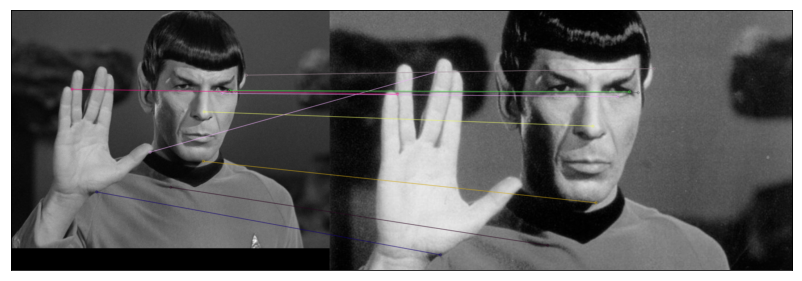

In [335]:
# visualize top 10 matches
matches_img = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
plt.imshow(matches_img)

### Hough Line Transform

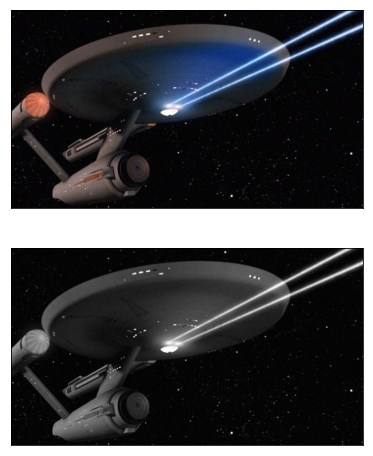

In [15]:
# load as BGR, convert to RGB, convert to grayscale, showcase
phasers = cv2.imread('enterprise_phasers.jpg', cv2.IMREAD_COLOR)[...,::-1]
phasers_gray = cv2.cvtColor(phasers, cv2.COLOR_RGB2GRAY)
ax1, ax2 = plt.subplots(2,1)[1]
ax1.imshow(phasers); ax2.imshow(phasers_gray, cmap='gray')

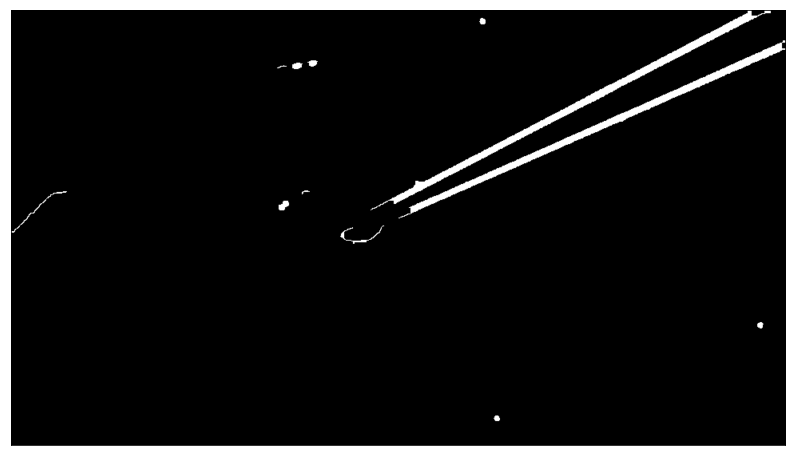

In [16]:
# isolate phaser rays
phaser_blur = cv2.blur(phasers_gray, (7,7))
phaser_edges = cv2.Canny(phaser_blur,128,256)
phaser_edges = cv2.morphologyEx(phaser_edges, cv2.MORPH_CLOSE, np.ones((7,7)))
plt.imshow(phaser_edges, cmap='gray')

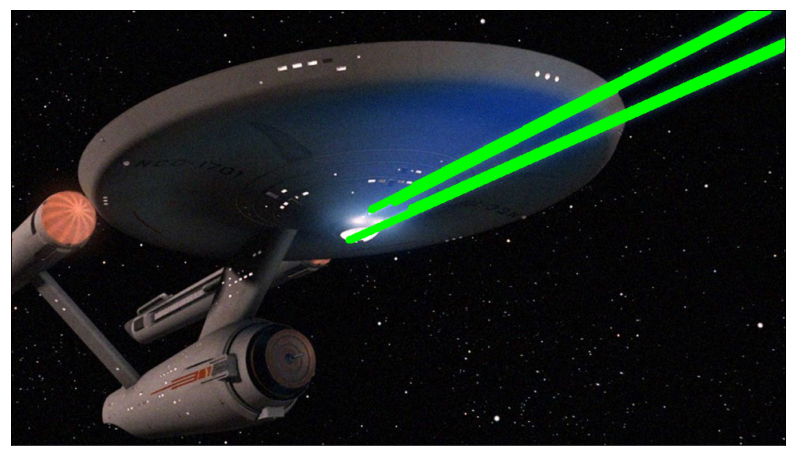

In [17]:
# find diagonal line terminal point coordinates
lines = cv2.HoughLinesP(phaser_edges, rho=1, theta=1.5*np.pi/180, threshold=256,
                        minLineLength=128, maxLineGap=64)

# draw found lines on image
phaser_lines = np.copy(phasers)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(phaser_lines,(x1,y1),(x2,y2),(0,255,0),7)

    # visualize result
plt.imshow(phaser_lines)

## Question 2

### K-Means Clustering

We'll cluster 8 random points (without replacement) from the range \[1,12\] into 3 different groups. 

In [18]:
# prints some data, plots cluster assignments
def plot_kmeans_step(pts, lbls, i, cntrs):
    plt.figure()
    plot = np.zeros((13,13,3),np.uint8)
    colors = np.where(lbls==0, (255,0,0), lbls)
    colors = np.where(lbls==1, (0,255,0), colors)
    colors = np.where(lbls==2, (0,0,255), colors)
    pts_y, pts_x = pts.astype(np.uint8).T
    plot[pts_y, pts_x] = colors
    plt.imshow(plot)
    plt.suptitle('iteration='+str(i)+', centers=\n'+str(cntrs))

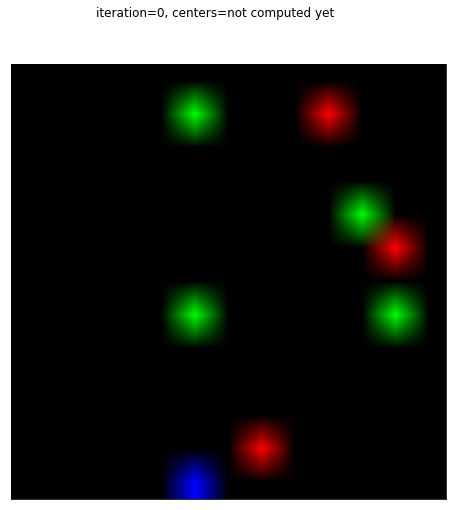

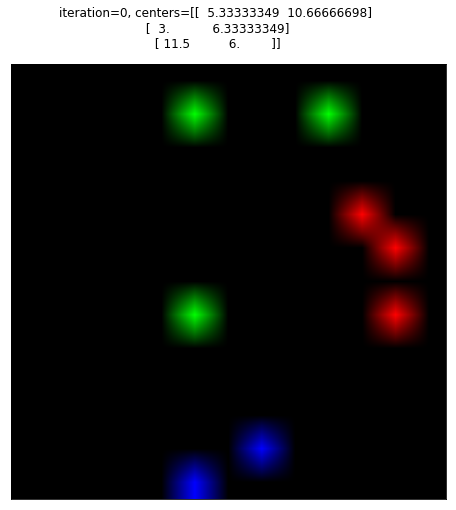

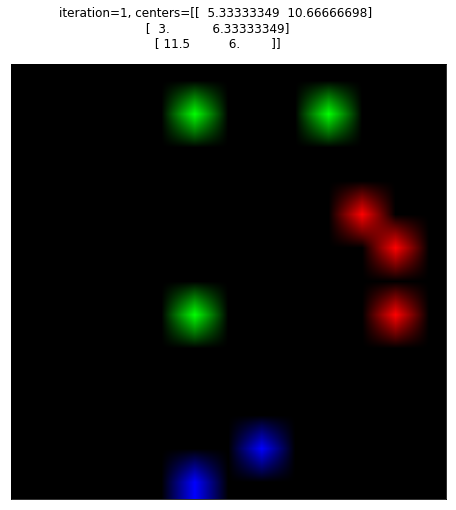

In [17]:
# select random 2d coordinates from valid range
pts = np.random.permutation(np.mgrid[1:13, 1:13].reshape(2, -1).T)[:8].astype(np.float32)
#  randomly set initial kmeans cluster assignments
lbls = np.random.choice(3,(8,1)).astype(np.int32)
# plot initial assignment
plot_kmeans_step(pts, lbls, 0, 'not computed yet')

# previous iteration's cluster centers
old_cntrs=None
for i in range(100):
    # run kmeans for 1 step
    ret,lbls,cntrs = cv2.kmeans(pts,
                                K=3, 
                                bestLabels=lbls, 
                                criteria=(cv2.TERM_CRITERIA_MAX_ITER, 1, 1.0), 
                                attempts=1, 
                                flags=cv2.KMEANS_USE_INITIAL_LABELS)
    # print some data, plot current cluster assignments
    plot_kmeans_step(pts, lbls, i, cntrs)
    # terminate loop when centers didn't change from last iteration
    if np.array_equal(cntrs, old_cntrs):
        break;
    old_cntrs=cntrs
    

## Question 3

### Least Squares Polynomial Fitting

#### Overview

We'll fit a parabolic curve to a set of 2d points using the least squares method.
The least squares method works by finding a curve such that the sum of the squared errors between the given coordinates and the curve is miniminal.

#### Math

The error is defined as 
$$ E = \Sigma_{i=0}^n (f(x_i) - y_i)^2 $$ 
Where $f(x)$ is our parabola fitting function and $x_i, y_i$ are the input coordinates.

We'll minimize the error by computing the vandermonde matrix
$$ \mathbf{y} = \mathbf{Xa} $$
Where $\mathbf y$ are the y coordinate column vector, $\mathbf X$ is the x coordinate polynomial power matrix, and $\mathbf a$ is the sought coefficient column vector.

_Note_: see [wolfram least squares polynomial fitting](http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)

In [299]:
# the specificed input coordinates
pts = np.array(((1,3.96), (4,27.96), (3,15.15), (5,45.8), (2,7.07), (6,69.4)))
pts

array([[  1.  ,   3.96],
       [  4.  ,  27.96],
       [  3.  ,  15.15],
       [  5.  ,  45.8 ],
       [  2.  ,   7.07],
       [  6.  ,  69.4 ]])

In [109]:
# calculate the x coordinate powers matrix
pts_x_pow = np.stack(((pts[:,0]**2).T, pts[:,0].T, np.ones(pts.shape[0]).T)).T
# solve the linear equation
dst = cv2.solve(pts[:,1],x, flags=cv2.DECOMP_NORMAL)[1]

_Note_: see [decomposition types](https://docs.opencv.org/3.1.0/d2/de8/group__core__array.html#gaaf9ea5dcc392d5ae04eacb9920b9674c)

In [110]:
# set curve x values 
curve_x = np.arange(13)
# calculate curve y values 
curve_x_pow = np.stack(((curve_x**2).T, curve_x.T, np.ones(curve_x.shape[0]).T)).T
curve_y = np.matmul(curve_x_pow,dst.T).ravel().astype(np.uint8)

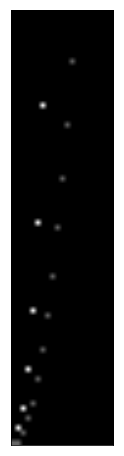

In [111]:
# plot input points and points on calculated curve
pts_x, pts_y = pts.astype(np.uint8).T
plot = np.zeros((89,21), np.uint8)
plot[pts_y, pts_x] = 255; plot[curve_y, curve_x] = 100
plt.imshow(plot[::-1,:], cmap='gray')

## Question 4

### Principal Component Analysis (PCA)

In [300]:
# set input points
pts = np.array(((2.5,2.9),(0.5,1.2),(2.2,3.4),(1.9,2.7),(3.1,3.5),(2.3,3.2),(2,2.1),
                (1,1.6),(1.5,2.1),(1.1,1.4))).T
pts.T

array([[ 2.5,  2.9],
       [ 0.5,  1.2],
       [ 2.2,  3.4],
       [ 1.9,  2.7],
       [ 3.1,  3.5],
       [ 2.3,  3.2],
       [ 2. ,  2.1],
       [ 1. ,  1.6],
       [ 1.5,  2.1],
       [ 1.1,  1.4]])

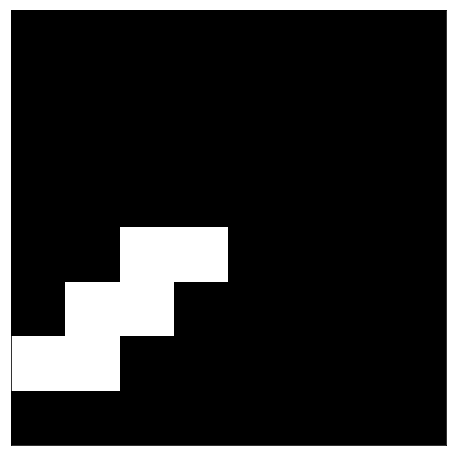

In [302]:
# plot input points
plot = np.zeros((8,8), np.uint8)
pts_x, pts_y = pts.astype(np.uint8)
plot[pts_y, pts_x] = 255
plt.imshow(plot[::-1,:], cmap='gray', interpolation='none')

In [303]:
# calculate covariance matrix, its eigenvalues and eigenvectors
eigval, eigvec = np.linalg.eig(np.cov(pts))
print('  eigenvalues: ', eigval)  
print('  eigenvectors: \n', eigvec)  # cols

  eigenvalues:  [ 0.0490834   1.28402771]
  eigenvectors: 
 [[-0.73517866 -0.6778734 ]
 [ 0.6778734  -0.73517866]]


_Note_: the principal components are defined as those having the largest eigenvalues.

In [304]:
# calculate projection into a 1d line
proj = np.matmul(eigvec.T[1], pts)*-1  # negative relation
proj

array([ 3.8267016 ,  1.22115109,  3.99092891,  3.27294183,  4.67453283,
        3.91168051,  2.89962197,  1.85415925,  2.56068527,  1.77491086])

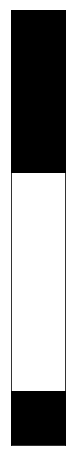

In [319]:
# plot projected line
plot = np.zeros((8,1), np.uint8)
plot[proj.astype(np.uint8), 0] = 150
plt.imshow(plot[::-1,:], cmap='gray', interpolation='none')

In [320]:
# calculate inverse projection back into 2d coordinates
inv_proj = np.matmul(eigvec,np.vstack((np.zeros(proj.shape[0]), proj)))*-1
inv_proj

array([[ 2.59401922,  0.82778584,  2.70534454,  2.2186402 ,  3.16874146,
         2.65162416,  1.9655766 ,  1.25688523,  1.73582043,  1.20316485],
       [ 2.81330934,  0.89776421,  2.93404575,  2.40619697,  3.43661676,
         2.87578402,  2.13174018,  1.3631383 ,  1.88256116,  1.30487658]])

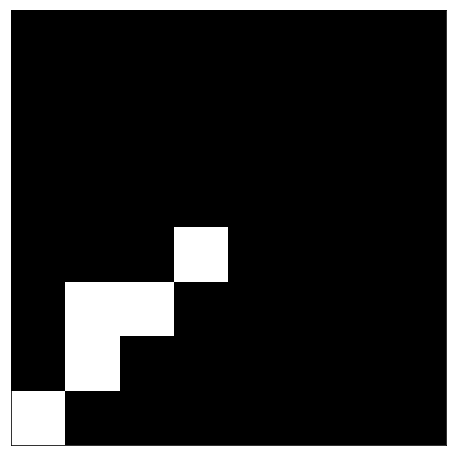

In [321]:
# plot backwards transformed result
plot = np.zeros((8,8), np.uint8)
plot[inv_proj[1].astype(np.uint8), inv_proj[0].astype(np.uint8)] = 255
plt.imshow(plot[::-1,:], cmap='gray', interpolation='none')